In [1]:
from typing import List
from __future__ import annotations
from abc import abstractmethod, ABC
import numpy as np
from utils import *
import glob
import random
from datetime import datetime

# Esta flag serve para ativar o download de um board do site.
# Entrentanto, SELENIUM é necessário
DOWNLOAD_NEW_BOARDS = False 

In [2]:
class Node(ABC):
    @abstractmethod
    def get_successors(self) -> List[Node]: 
        pass

    @abstractmethod
    def distance_from(self, node: Node) -> Node:
        pass
    
    @abstractmethod
    def calculate_heuristic_cost(self, target: Node) -> Node:
        pass
    
    @abstractmethod
    def is_goal_node(self) -> bool:
        pass

    @abstractmethod
    def __eq__(self, node: Node) -> bool:
        pass

In [3]:
class GameNode(Node):
    def __init__(self, board, parent:GameNode = None):
        self.board = board
        self.parent = parent
        self.h = None
        self.f = None
        
        if parent is not None:
            self.g = self.parent.g + 1
        else:
            self.board = change_whites(self.board)
            self.g = 0

        self.board_id = self.board.flatten().tobytes()


    def get_successors(self) -> List[Node]: 
        white_mask = self.board == WHITE 
        if (self.board == MUST_WHITE).any():
            white_mask = self.board == MUST_WHITE 

        successors = []
        for x,y in np.argwhere(white_mask):
            board_copy = self.board.copy()
            board_copy[x,y] = LIGHT
            if check_new_light(board_copy, x, y):
                s = GameNode(board_copy, self)
                successors.append(s)

        return successors

    def distance_from(self, node: GameNode) -> int:
        if node == self.parent:
            return self.parent.g + 1
        return (self.board == LIGHT).sum() - (node.board == LIGHT).sum()

    def calculate_heuristic_cost(self, target: GameNode = None) -> int:
        return (self.board[self.board <= 4]**2).sum() + (self.board == WHITE).sum()

    def is_goal_node(self, target: GameNode = None) -> bool:
        return ((self.board != WHITE) & (self.board != INVALID_WHITE)).all() and ((self.board > 4) | (self.board == 0)).all()

    def __eq__(self, node: GameNode) -> bool:
        return self.board_id == node.board_id
    
    def __repr__(self) -> str:
        return str(self.board)

In [4]:
def a_star(start_node: Node, goal_node: Node):
    open_nodes = [start_node]
    closed_nodes = []
    
    while len(open_nodes) > 0:
        node = min(open_nodes, key=lambda n: n.f)
        open_nodes.remove(node)
        if  node.is_goal_node(goal_node):
            return node, open_nodes, closed_nodes
            
        successors = node.get_successors()

        for s in successors:
            s.f = s.g + s.calculate_heuristic_cost(goal_node)
            
            if s in open_nodes:
                idx = open_nodes.index(s)
                s2 = open_nodes[idx]
                if s2.g <= s.g:
                    continue
                else:
                    open_nodes.remove(s2)
                    open_nodes.append(s) 

            elif s in closed_nodes:
                idx = closed_nodes.index(s)
                s2 = closed_nodes[idx]
                if s2.g <= s.g:
                    continue
                else:
                    open_nodes.append(s)
                    closed_nodes.remove(s2)

            else:
                open_nodes.append(s)
                
        closed_nodes.append(node)

     



====== WebDriver manager ======
Current google-chrome version is 93.0.4577
Get LATEST driver version for 93.0.4577
Driver [C:\Users\gusta\.wdm\drivers\chromedriver\win32\93.0.4577.63\chromedriver.exe] found in cache


https://www.chiark.greenend.org.uk/~sgtatham/puzzles/js/lightup.html#7x7b20s4d2#140544371580289


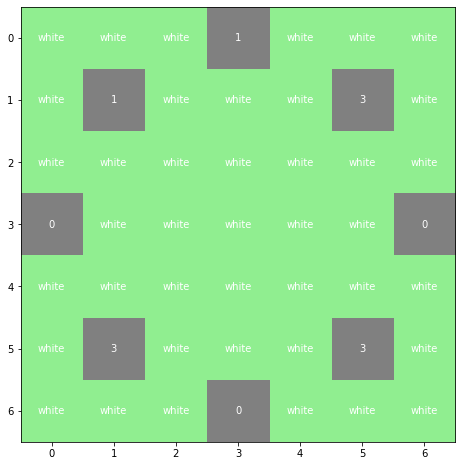

In [33]:
# gets a new board from the website
if DOWNLOAD_NEW_BOARDS:
    from crawler import get_random_board
else:
    get_random_board = lambda: np.load(random.choice(glob.glob('./boards/*.npy')))

board = get_random_board()

if DOWNLOAD_NEW_BOARDS:
    np.save(f"boards/{datetime.now().strftime('%Y%m%d%H%M%S')}", board)
    
plot_board(board).savefig("problema.eps");

In [34]:
# create start and goal nodes
start_node = GameNode(board)
goal_board = board.copy()
goal_board[goal_board == WHITE] = ILUMI
goal_node = GameNode(goal_board)
start_node.h = start_node.calculate_heuristic_cost(goal_node)

In [35]:
# A* + final processing
result, open_nodes, closed_nodes = a_star(start_node, goal_node)
final_result = np.where((start_node.board >= 0) & (start_node.board <= 4), start_node.board, result.board)

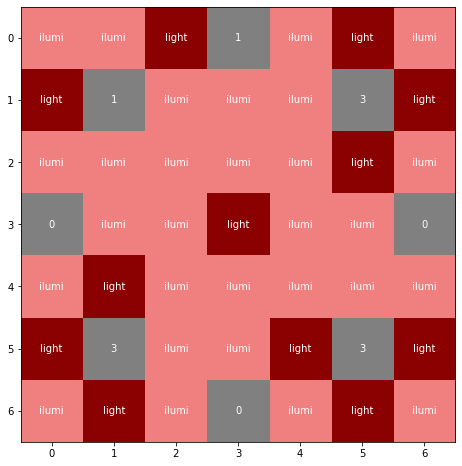

In [36]:
plot_board(final_result).savefig("solução.eps");

In [13]:
x = result
path = [x]
while x.parent is not None:
    path.append(x.parent)
    x = x.parent
path = path[::-1]

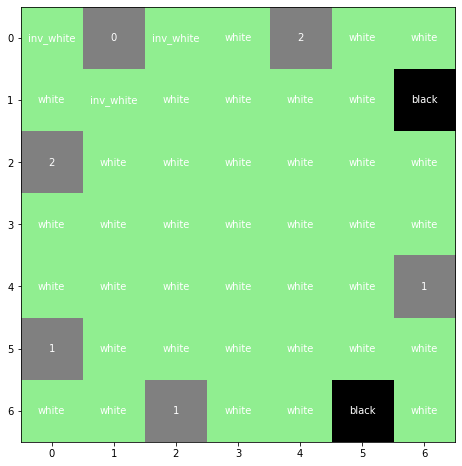

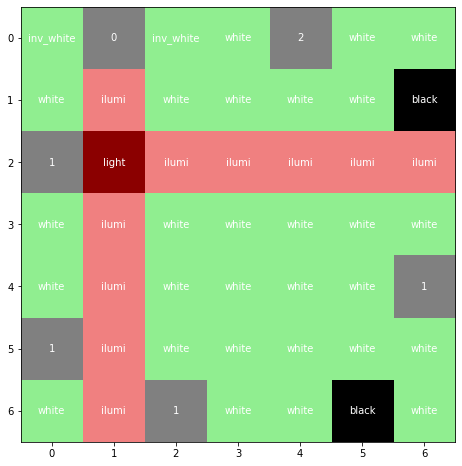

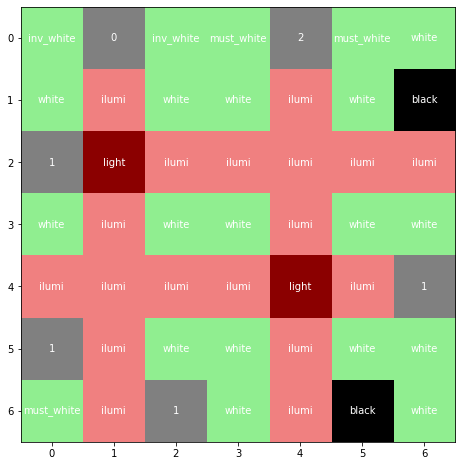

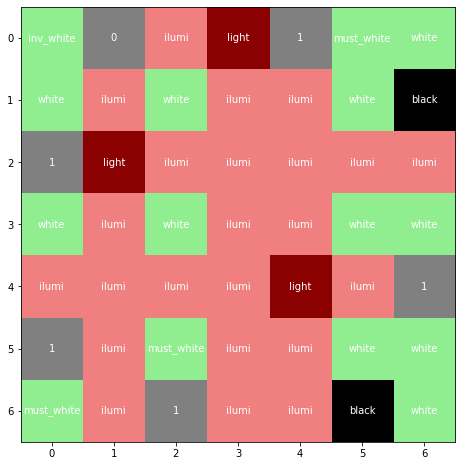

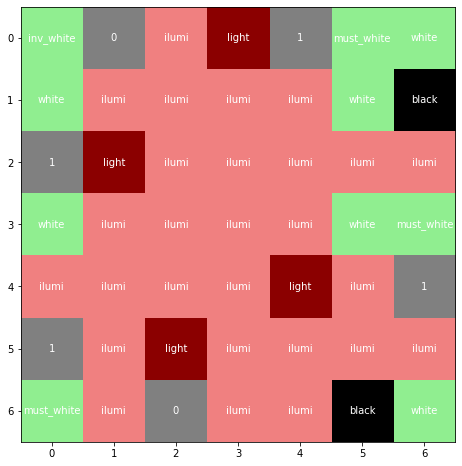

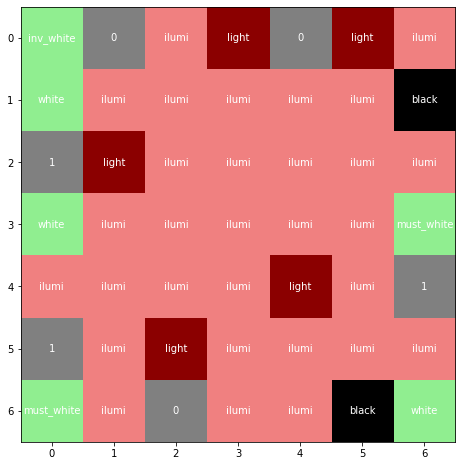

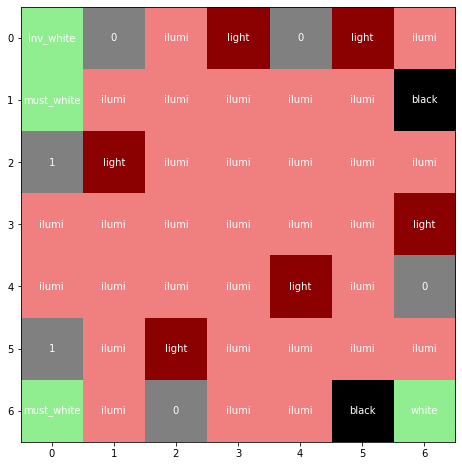

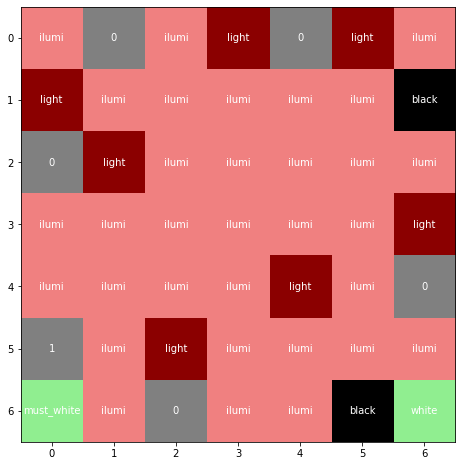

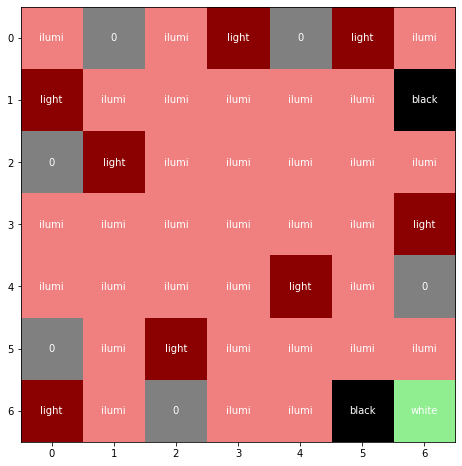

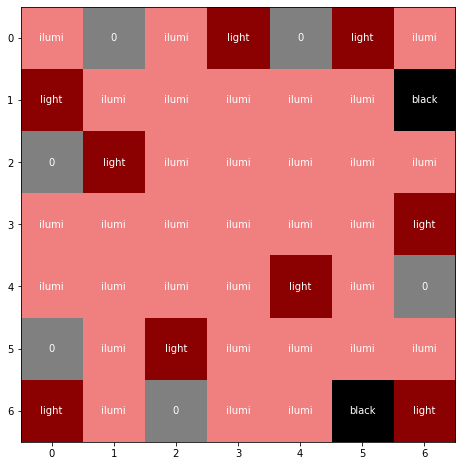

In [15]:
for n in path:
    plot_board(n.board)